In [26]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
import zipfile
import os

zip_path = "/content/archive.zip"
extract_path = "/content/fer2013"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped at:", extract_path)


Dataset unzipped at: /content/fer2013


In [4]:
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Test data (only rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


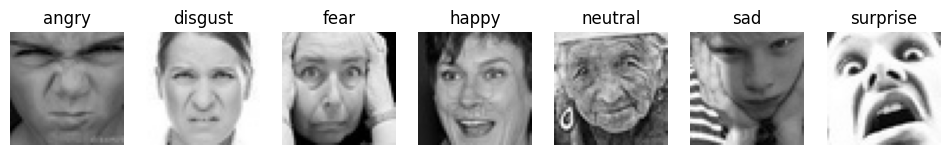

In [7]:
# Show 1 image per category
categories = list(train_gen.class_indices.keys())
plt.figure(figsize=(12,4))
for i, cat in enumerate(categories):
    cat_dir = os.path.join(train_dir, cat)
    img_name = os.listdir(cat_dir)[0]  # pick first image
    img_path = os.path.join(cat_dir, img_name)
    img = load_img(img_path, target_size=(48,48))
    plt.subplot(1, len(categories), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(cat)
    plt.axis('off')
plt.show()



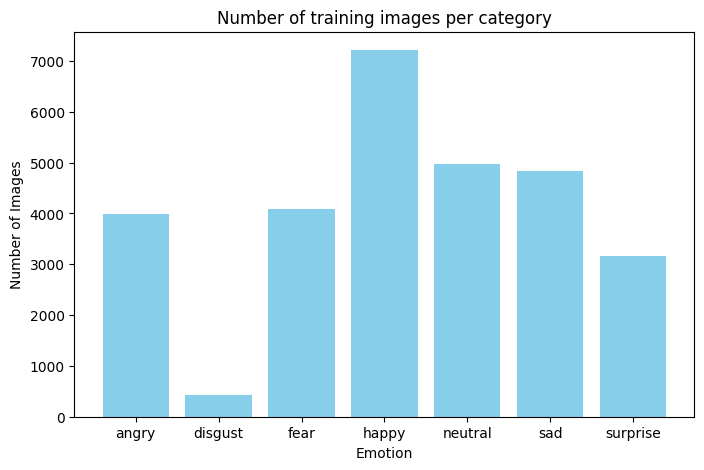

In [6]:

# Bar graph: number of images per category
counts = [len(os.listdir(os.path.join(train_dir, c))) for c in categories]
plt.figure(figsize=(8,5))
plt.bar(categories, counts, color='skyblue')
plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.title("Number of training images per category")
plt.show()

In [8]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotions
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=test_gen
)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.2302 - loss: 1.8380 - val_accuracy: 0.2517 - val_loss: 1.7857
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.2538 - loss: 1.7870 - val_accuracy: 0.2952 - val_loss: 1.7205
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.2725 - loss: 1.7545 - val_accuracy: 0.3153 - val_loss: 1.6804
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.2952 - loss: 1.7190 - val_accuracy: 0.3851 - val_loss: 1.5770
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.3366 - loss: 1.6500 - val_accuracy: 0.4218 - val_loss: 1.4898


In [14]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {val_acc*100:.2f}%")


Final Training Accuracy: 34.42%
Final Validation Accuracy: 42.18%


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


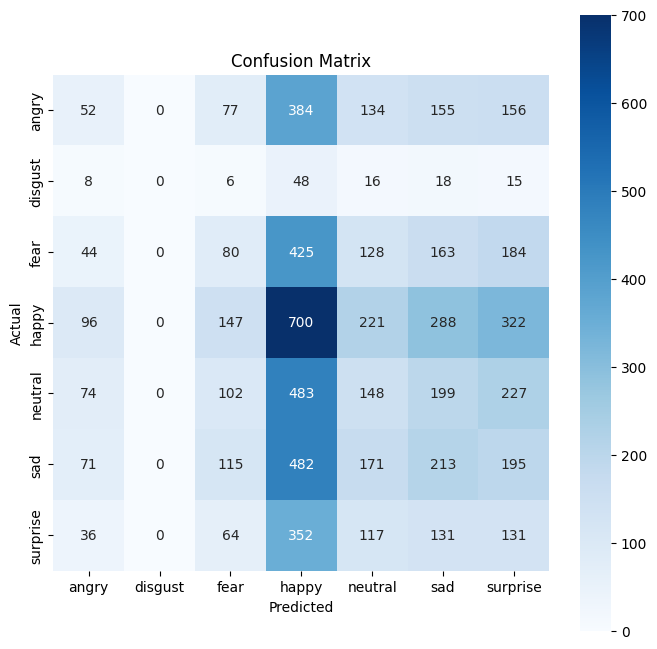

In [30]:
# True and predicted labels
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_names = list(test_gen.class_indices.keys())

# Confusion matrix (raw counts)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, square=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()


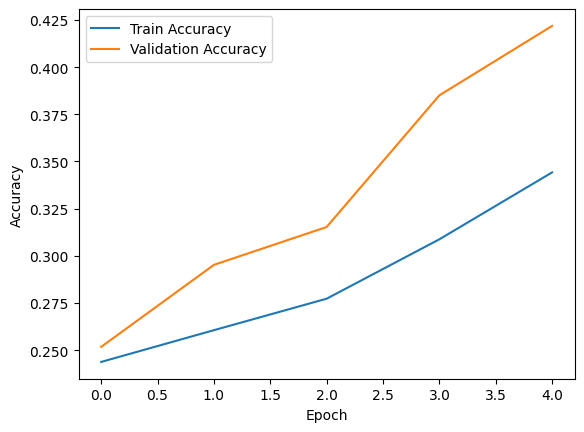

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


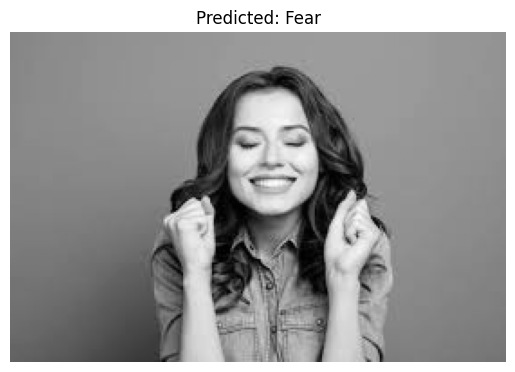

Predicted Emotion: Fear


In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

emotion_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

def predict_external_image(img_path):

    img_display = load_img(img_path, color_mode='grayscale')


    img_model = load_img(img_path, target_size=(48,48), color_mode='grayscale')
    img_array = img_to_array(img_model)/255.0
    img_input = np.expand_dims(img_array, axis=0)


    pred_idx = np.argmax(model.predict(img_input)[0])
    emotion = emotion_labels[pred_idx]


    plt.imshow(np.array(img_display), cmap='gray')
    plt.title(f"Predicted: {emotion}")
    plt.axis('off')
    plt.show()

    print("Predicted Emotion:", emotion)


predict_external_image("/content/download.jpg")
